In [1]:
#importing all necessary libraries for math, data processing, and ML models

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf


# Load dataset
df = pd.read_csv('electrolytes.csv')

# Preprocess the data
scaler = MinMaxScaler()
df[['time', 'T1']] = scaler.fit_transform(df[['time', 'T1']])



In [2]:
df.head()

,T1,T2,T3,T4,time
0,0.325129,91.4634,60.4839,59.2885,0.000000
1,0.325129,91.4634,60.4839,59.2885,0.000556
2,0.318892,91.1834,60.4606,59.2885,0.001112
3,0.366681,91.8788,60.3391,58.8973,0.001668
4,0.413354,91.1772,60.0762,58.4359,0.002223


1611
179
1611
179
Epoch 1/100
46/46 [==============================] - 4s 22ms/step - loss: 0.0659 - accuracy: 6.8582e-04 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0195 - accuracy: 6.9013e-04 - val_loss: 0.0151 - val_accuracy: 0.0000e+00
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0187 - accuracy: 6.9013e-04 - val_loss: 0.0179 - val_accuracy: 0.0000e+00
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0194 - accuracy: 6.9013e-04 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0193 - accuracy: 6.9013e-04 - val_loss: 0.0163 - val_accuracy: 0.0000e+00
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0189 - accuracy: 6.9013e-04 - val_loss: 0.0151 - val_accuracy: 0.0000e+00
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0187 - accur

ValueError: x and y must have same first dimension, but have shapes (179,) and (1790,)

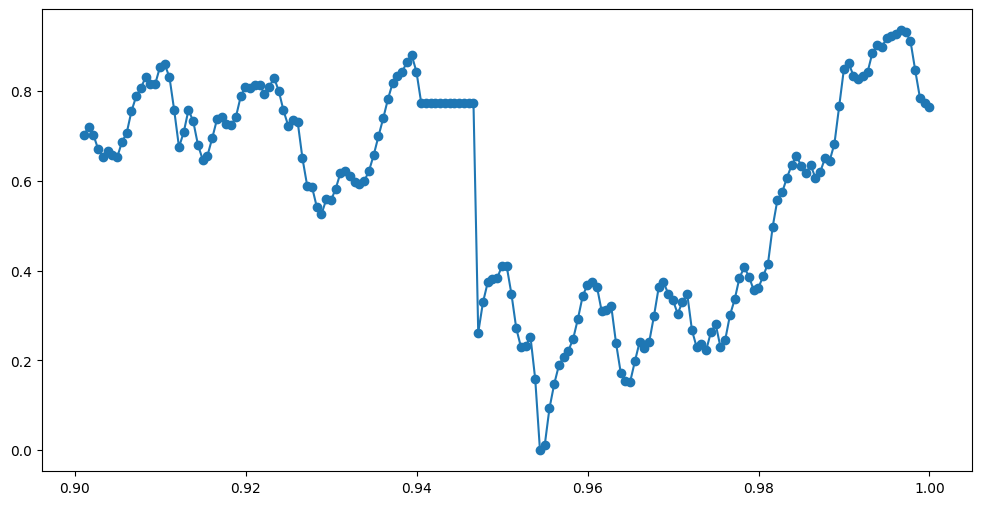

In [16]:
#importing all necessary libraries for math, data processing, and ML models

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf


# Load dataset
df = pd.read_csv('electrolytes.csv')

# Preprocess the data
scaler = MinMaxScaler()
df[['time', 'T1']] = scaler.fit_transform(df[['time', 'T1']])

def create_time_series_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Set time_steps and create the time series dataset
time_steps = 10  # Hyperparameter to adjust
X, y = create_time_series_dataset(df['T1'], df['T1'], time_steps)
train_size = int(len(X) * 0.9) # 90-10 split for train and test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape(X_train.shape[0], time_steps, 1)
X_test = X_test.reshape(X_test.shape[0], time_steps, 1)

print(len(X_train))

print(len(X_test))

print(len(y_train))

print(len(y_test))

# Define encoder inputs
encoder_inputs = keras.layers.Input(shape=(time_steps, 1))

# Define encoder LSTM layer
encoder_lstm = keras.layers.LSTM(units=128, return_sequences=False)(encoder_inputs)

# Define decoder inputs
decoder_inputs = keras.layers.Input(shape=(time_steps, 1))

# Pass encoder output to decoder LSTM layer
decoder_lstm = keras.layers.LSTM(units=128, return_sequences=True)(decoder_inputs, initial_state=[encoder_lstm, encoder_lstm])

# Add dropout layer
dropout = keras.layers.Dropout(rate=0.2)(decoder_lstm)

# Add dense layer
dense = keras.layers.Dense(units=1)(dropout)

# Define model
model = keras.models.Model([encoder_inputs, decoder_inputs], dense)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model.fit(
    [X_train, X_train], y_train, # Both encoder and decoder inputs are X_train
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

6/6 [==============================] - 0s 4ms/step
0.029110753908753395


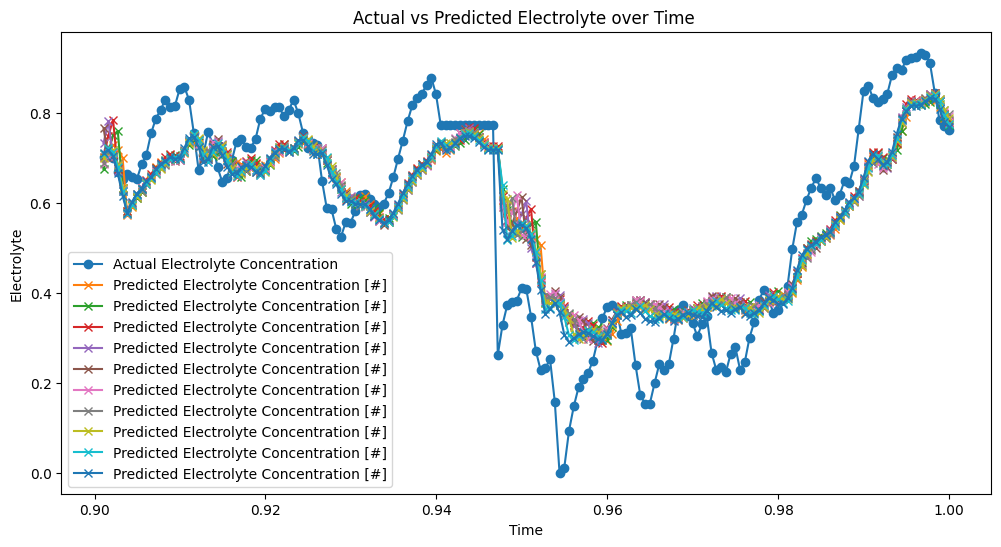

In [36]:
# Evaluate the model on the test set
mse, accuracy = model.evaluate([X_test, X_test], y_test) # Both encoder and decoder inputs are X_test
predictions = model.predict([X_test, X_test]) # Both encoder and decoder inputs are X_test

# Avoid division by zero
non_zero_mask = y_test != 0

# Reshape predictions array to have shape (179, 10)
predictions = predictions.reshape(predictions.shape[0], time_steps)

print(mse)
#print(f'Percent Error on Test Set: {percent_error:.2f}%')
plt.figure(figsize=(12, 6))
plt.plot(df['time'].values[time_steps + train_size:], y_test, label='Actual Electrolyte Concentration', marker='o')
plt.plot(df['time'].values[time_steps + train_size:], predictions, label='Predicted Electrolyte Concentration [#]', marker='x')
plt.xlabel('Time')
plt.ylabel('Electrolyte')
plt.title('Actual vs Predicted Electrolyte over Time ')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf

tflite_model_name = 'heart_model'  # Will be given .tflite suffix

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Disable lower tensor list ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)


In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
c_model_name = 'heart_model'
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))